In [1]:
import sys
import pandas as pd
from datatransformer import DataTransformerDeep
sys.path.insert(0, 'C:/Udvikler/Speciale/SpecialeKode')
from utils import *
import itertools
from model_evaluation.RFQModelEval import RFQModelEval, eval_utils
from DeepRFQAgent import DeepRFQAgent
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For boxplot legend entries
import matplotlib.lines as mlines  # For axhline legend entry

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#Not to make the kernel crash
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# Read the CSV file into a pandas DataFrame
file_path = "../data/data_inventory_risk.csv"
df = pd.read_csv(file_path)

# Datetime format
df["TradeTime"] = pd.to_datetime(df["TradeTime"], format="%m/%d/%Y %H:%M:%S")

#Split into train and test set  
train_df, val_df = split_data(df, 0.9)

In [ ]:
#Configs 

sample_methods = [
    #"random",
    "time_biased"
]

alphas = [#"0.25",
          "0.5",
          #"0.75"
        ]


all_features = [
    #["bpv_risk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["bpv_risk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "delta_h_t", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["bpv_risk","delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["inventoryRisk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "delta_h_t", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["inventoryRisk", "delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"]
]

all_reward_functions = [
    inventory_PnL_reward,
    risk_PnL_reward,
    hitrate_target_reward,
    linearMarginReward,
    quadraticMarginReward
]

learning_algorithms = [
    'random_by_action_distr',
    'random_by_uniform',
    'CQL'
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
           "meanMLSharpeRatio", "meanDealerSharpeRatio", "meanDealerSharpeRatioNoNeg", "DealerNetInventoryDiff", "MLNetInventoryDiff"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm, sample_method, alpha)
     for features, reward_function, learning_algorithm, sample_method, alpha in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms, sample_methods, alphas)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward")))],
    names=["Features", "Reward Function", "Learning Algorithm", "Sample method", "Alpha"]
)

In [5]:
#for idx in index:
#    print(idx)

In [6]:
# Initialize an empty DataFrame with the MultiIndex
results_df = pd.DataFrame(columns=metrics, index=index)

n_trials = 3  # Number of trials per combination

# Iterate over all combinations and collect results
for features, reward_function, learning_algorithm, sample_method, alpha in itertools.product(all_features, all_reward_functions, 
                                                                                             learning_algorithms, sample_methods, alphas):
    
    # Apply the condition to skip unwanted combinations
    if not (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward"))):
        continue
    
     # Handle random policies: Only one experiment for these algorithms
    if learning_algorithm in ['random_by_action_distr', 'random_by_uniform']:
        # Perform a single experiment for each random policy, independent of other parameters
        if features != all_features[0] or reward_function != all_reward_functions[0] or sample_method != sample_methods[0] or alpha != alphas[0]:
            continue  # Skip all other combinations for random algorithms

    features_key = ",".join(features)
    key = (features_key, reward_function.__name__, learning_algorithm, sample_method, alpha)
    
    print("key: ", key)
    # Store all trial results for this combination
    trial_results = []
    
    for trial in range(n_trials):  # Repeat the experiment multiple times
        print(f"Combination: {key}, Trial: {trial + 1}/{n_trials} \n")
        
        opponent_actions = learning_algorithm in ["CQL_MarkovGame"]
        discretize_actions = False if learning_algorithm == "BCQ" else True
        reward_terms = True if learning_algorithm == "CQL_Segmented" else False

        data_transformer = DataTransformerDeep(
            input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15,
            reward_function=reward_function, opponent_actions=opponent_actions, 
            discretize_actions=discretize_actions,
            reward_terms=reward_terms)
        
        agent = DeepRFQAgent(data_transformer=data_transformer, random=True)
        agent.train(train_df.copy(), algorithm=learning_algorithm, num_train_steps=4000, batch_size=256, 
                    follow_progress=False, alpha=float(alpha), sample_method=sample_method)

        modelEvaluator = RFQModelEval(agent)
        modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=False, 
                                               print_violin_plot=False, plot_spreads=False, random_policy=False)
        
        # Append the metrics of the current trial
        trial_results.append(modelPerformance[metrics])  
    
    # Store results as a DataFrame for this combination
    trial_results_df = pd.DataFrame(trial_results)  # Convert list of dicts to a DataFrame
    results_df.loc[key] = trial_results_df.mean()  # Store the mean as the final result, or customize as needed
    
    # Optionally save trial results for further analysis
    trial_results_df.to_csv(f"experiments_results/results_{features_key}_{reward_function.__name__}_{learning_algorithm}_{sample_method}_{alpha}.csv")

key:  ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'CQL', 'time_biased', '0.5')
Combination: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'CQL', 'time_biased', '0.5'), Trial: 1/3 

seed:  130
QNetworkSkipConnection(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=137, out_features=155, bias=True)
)
Desired HR: 22.871376811594203 

Combination: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'CQL', 'time_biased', '0.5'), Trial: 2/3 

seed:  197
QNetworkSkipConnection(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=137, out_features=155, bias=True)
)
Desired HR: 22.871376811594203 

Combination: ('bpv_risk,Duration,Amount,Si

KeyboardInterrupt: 

In [ ]:
all_results = []

for idx in index:

    
    file_path = f"experiments_results/results_{idx[0]}_{idx[1]}_{idx[2]}_{idx[3]}_{idx[4]}.csv"
  
    if not os.path.exists(file_path):
        print(f"Warning: Results file not found for {idx}. Skipping.")
        continue  # Skip missing file
    
    trial_data = pd.read_csv(file_path)  # Load stored trial data

    # Extract relevant parts of the key
    features_key = idx[0].split(",")[0]  # Get the first feature from the feature list
    reward_function_key = idx[1]         # Reward function name
    algorithm_key = idx[2]               # Algorithm name
    
    features = idx[0].split(",")
    if "h_t" in features:
        features_key += "_h_t"
    
    # Create a simplified combination label
    if algorithm_key in ['random_by_action_distr', 'random_by_uniform']:
        # For random policies, use only the algorithm name
        simplified_key = algorithm_key
    else:
        # For other algorithms, include first feature, reward function, and algorithm
        simplified_key = f"{features_key}_{reward_function_key}_{algorithm_key}"

    trial_data['Combination'] = simplified_key  # Add the simplified label
    all_results.append(trial_data)
    
# Concatenate all results into a single DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

all_results_df['Combination'].unique()

array(['random_by_action_distr', 'random_by_uniform',
       'bpv_risk_risk_PnL_reward_CQL', 'bpv_risk_linearMarginReward_CQL',
       'bpv_risk_quadraticMarginReward_CQL',
       'bpv_risk_hitrate_target_reward_CQL',
       'inventoryRisk_inventory_PnL_reward_CQL',
       'inventoryRisk_linearMarginReward_CQL',
       'inventoryRisk_quadraticMarginReward_CQL',
       'inventoryRisk_hitrate_target_reward_CQL'], dtype=object)

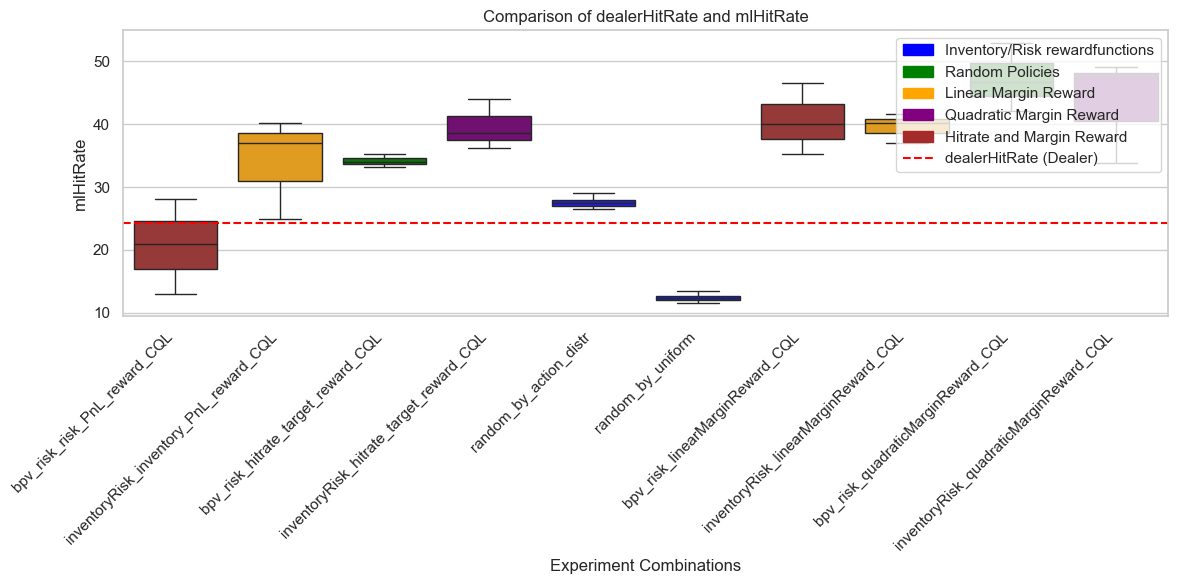

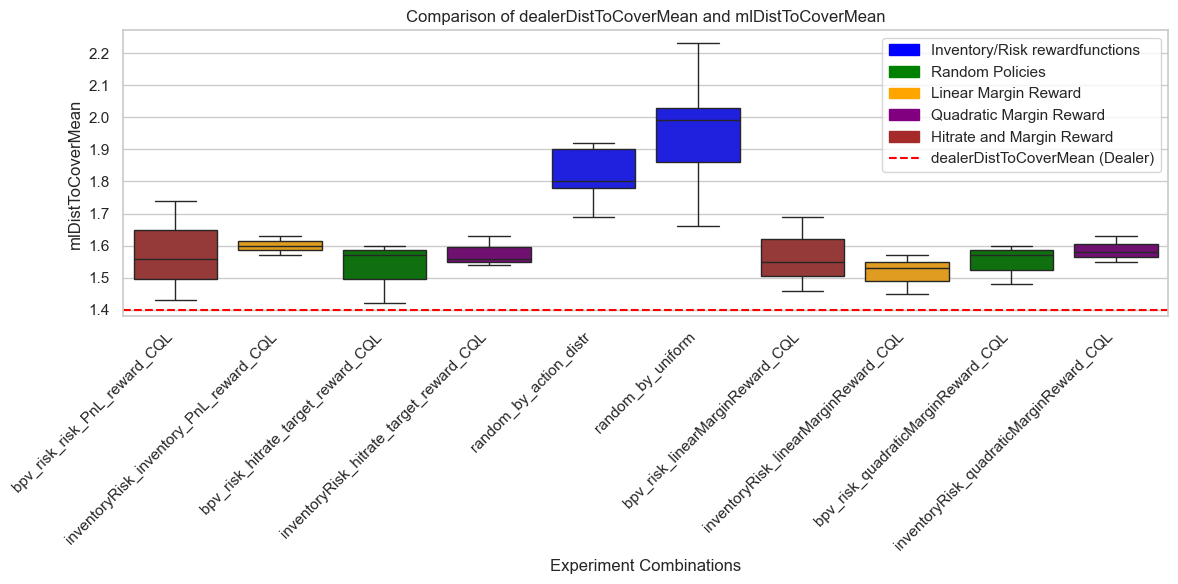

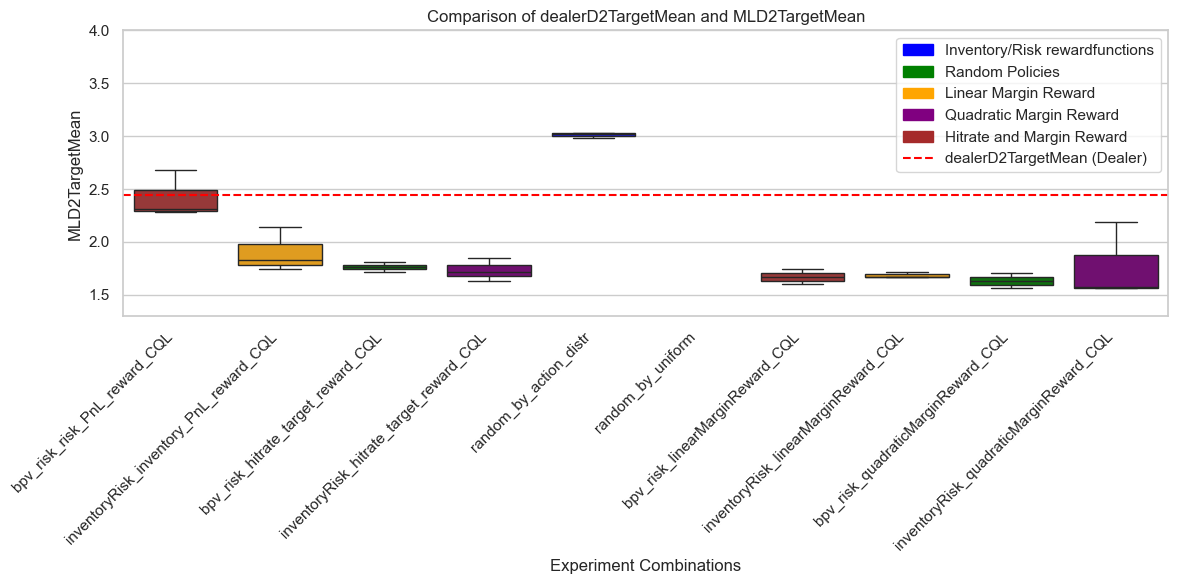

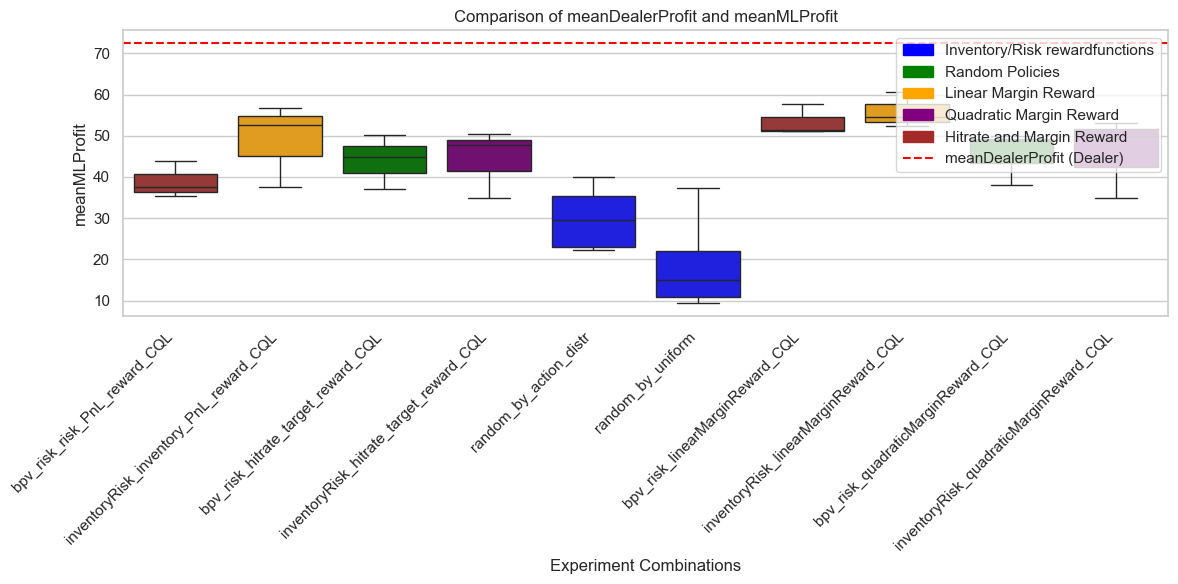

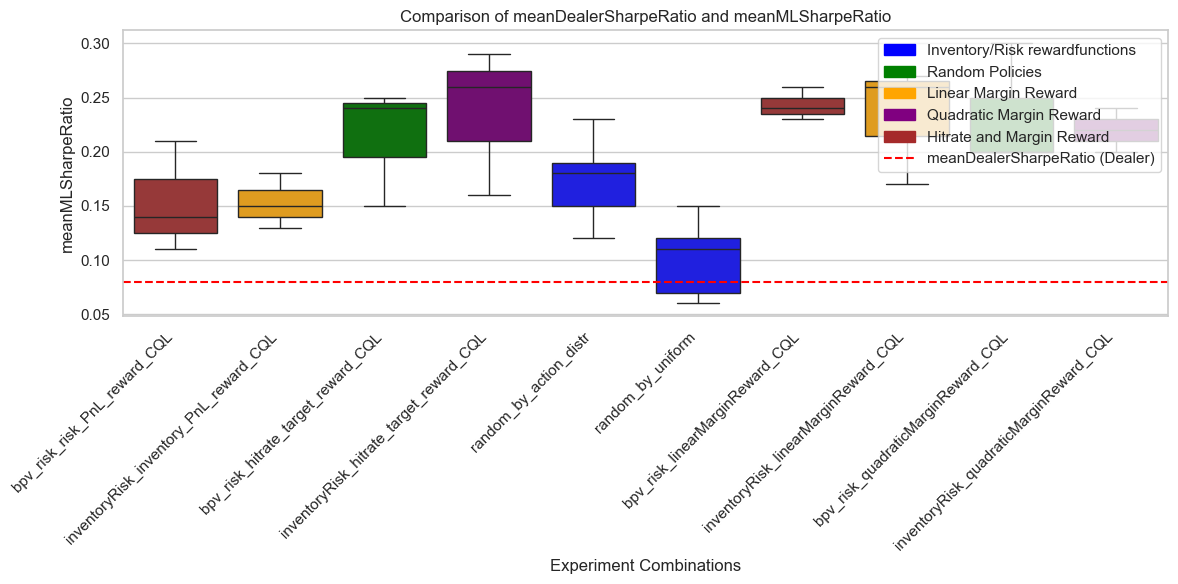

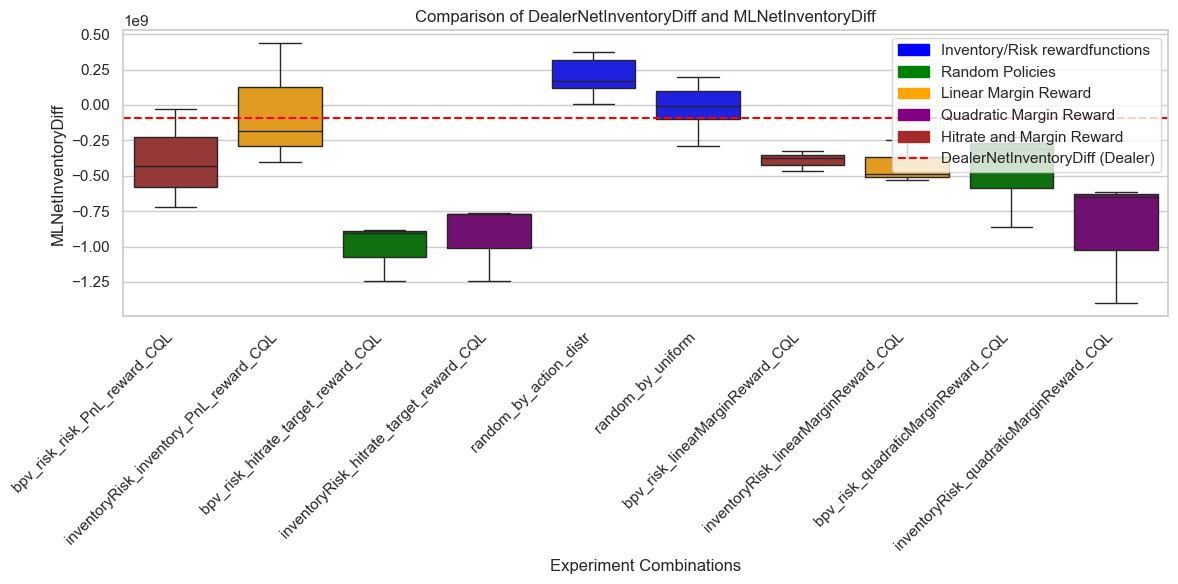

In [ ]:
# Separate metrics into ML and Dealer pairs
metrics = [
    ("dealerHitRate", "mlHitRate"), 
    ("dealerDistToCoverMean", "mlDistToCoverMean"),
    ("dealerD2TargetMean", "MLD2TargetMean"),
    ("meanDealerProfit", "meanMLProfit"),
    ("meanDealerSharpeRatio", "meanMLSharpeRatio"),
    ("DealerNetInventoryDiff", "MLNetInventoryDiff")
]

sns.set_theme(style="whitegrid")

# Define custom colors
reward_colors = {'linearMarginReward': 'orange', 'quadraticMarginReward': 'purple', 'hitrate_target_reward': 'brown'}
default_color = 'blue'  # Default boxplot color for DQN configurations
random_color = 'green'  # Color for random policies

# Assign colors based on combination
palette = {}
for combination in all_results_df['Combination'].unique():
    if 'random_by_action_distr' in combination or 'random_by_uniform' in combination:
        palette[combination] = random_color
    elif 'linearMarginReward' in combination:
        palette[combination] = reward_colors['linearMarginReward']
    elif 'quadraticMarginReward' in combination:
        palette[combination] = reward_colors['quadraticMarginReward']
    elif 'hitrate_target_reward' in combination:
        palette[combination] = reward_colors['hitrate_target_reward']
    else:
        palette[combination] = default_color

# Determine the order of combinations for grouped colors
ordered_combinations = sorted(palette, key=lambda x: palette[x])

# Plotting loop
for dealer_metric, ml_metric in metrics:
    plt.figure(figsize=(12, 6))
    
    # Boxplot for ML metrics
    sns.boxplot(
        data=all_results_df, 
        x="Combination", 
        y=ml_metric, 
        palette=[palette[comb] for comb in ordered_combinations],  # Use ordered colors
        order=ordered_combinations,  # Group by color
        showfliers=False,
        hue="Combination",
        legend=False
    )
    
    # Overlay dealer metric as a horizontal line
    dealer_value = all_results_df[f"{dealer_metric}"].mean()
    axhline = plt.axhline(
        y=dealer_value, 
        color='red', 
        linestyle='--', 
        label=f"{dealer_metric} (Dealer)"
    )

    if ml_metric == 'MLD2TargetMean':
        #plt.yscale('log')
        plt.ylim(top=4.0)

    # Add a custom legend for boxplot colors and dealer line
    legend_patches = [
        mpatches.Patch(color=default_color, label='Inventory/Risk rewardfunctions'),
        mpatches.Patch(color=random_color, label='Random Policies'),
        mpatches.Patch(color=reward_colors['linearMarginReward'], label='Linear Margin Reward'),
        mpatches.Patch(color=reward_colors['quadraticMarginReward'], label='Quadratic Margin Reward'),
        mpatches.Patch(color=reward_colors['hitrate_target_reward'], label='Hitrate and Margin Reward'),
        mlines.Line2D([], [], color='red', linestyle='--', label=f"{dealer_metric} (Dealer)")
    ]
    plt.legend(handles=legend_patches, loc="upper right")
    
    # Set plot title and labels
    plt.title(f"Comparison of {dealer_metric} and {ml_metric}")
    plt.xlabel("Experiment Combinations")
    plt.ylabel(ml_metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Show plot
    plt.show()

Mean Field Experiments

In [ ]:
#Configs 

sample_methods = [
    #"random",
    "time_biased"
]

alphas = [#"0.25",
          "0.5",
          #"0.75"
        ]


all_features = [
    #["bpv_risk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["bpv_risk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "delta_h_t", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk","delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["inventoryRisk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "delta_h_t", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"]
]

all_reward_functions = [
    inventory_PnL_reward,
    risk_PnL_reward,
    #hitrate_target_reward,
    #linearMarginReward,
    #quadraticMarginReward
]

learning_algorithms = [
    #'random_by_action_distr',
    #'random_by_uniform',
    'CQL_Segmented'
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
           "meanMLSharpeRatio", "meanDealerSharpeRatio", "meanDealerSharpeRatioNoNeg", "DealerNetInventoryDiff", "MLNetInventoryDiff"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm, sample_method, alpha)
     for features, reward_function, learning_algorithm, sample_method, alpha in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms, sample_methods, alphas)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward")))],
    names=["Features", "Reward Function", "Learning Algorithm", "Sample method", "Alpha"])

In [ ]:
for features, reward_function, learning_algorithm, sample_method, alpha in itertools.product(all_features, all_reward_functions, 
                                                                                             learning_algorithms, sample_methods, alphas):
    # Skip invalid combinations
    if not (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
            ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
            (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward"))):
        continue 
    
    # Create MultiIndex-compatible key
    features_key = ",".join(features)  # Join features into a string
    key = (features_key, reward_function.__name__, learning_algorithm, sample_method, alpha)
    print(f"Processing Key: {key}")
    
    # Initialize components and train agent
    opponent_actions = learning_algorithm in ["CQL_MarkovGame"]
    discretize_actions = False if learning_algorithm == "BCQ" else True
    reward_terms = True if learning_algorithm == "CQL_Segmented" else False

    data_transformer = DataTransformerDeep(
        input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15,
        reward_function=reward_function, opponent_actions=opponent_actions, 
        discretize_actions=discretize_actions,
        reward_terms=reward_terms)
    
    agent = DeepRFQAgent(data_transformer=data_transformer, random=True)
    agent.train(train_df.copy(), algorithm=learning_algorithm, num_train_steps=4000, batch_size=256, 
                follow_progress=False, alpha=float(alpha), sample_method=sample_method)

    modelEvaluator = RFQModelEval(agent)
    modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=False, 
                                            print_violin_plot=False, plot_spreads=False, random_policy=False)
    
    # Extract metrics safely
    modelPerformanceSubset = {metric: modelPerformance.get(metric, np.nan) for metric in metrics}
    print(f"Metrics for {key}: {modelPerformanceSubset}")
    
    # Update results_df
    results_df.loc[key] = pd.Series(modelPerformanceSubset)

# Display the results DataFrame
print("Final Results DataFrame:")
print(results_df)


Processing Key: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'CQL_Segmented', 'time_biased', '0.5')
seed:  42
Desired HR: 22.871376811594203 

Metrics for ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'CQL_Segmented', 'time_biased', '0.5'): {'dealerHitRate': 24.36, 'mlHitRate': 14.46, 'MLWinShare': 8.738395676583178, 'mlDistToCoverMean': 1.83, 'mlDistToCoverStd': 1.9672148641254987, 'dealerDistToCoverMean': 1.4, 'meanMLProfit': 34.2, 'meanDealerProfit': 72.4, 'meanRLReward': 0.9775461782178165, 'dealerD2TargetMean': 2.44, 'MLD2TargetMean': 2.51, 'MLD2TargetStd': 1.903169681567065, 'meanMLSharpeRatio': 0.1, 'meanDealerSharpeRatio': 0.08, 'meanDealerSharpeRatioNoNeg': 0.08, 'DealerNetInventoryDiff': -91551625.08999991, 'MLNetInventoryDiff': -37526865.03999996}
Processing Key: ('inventoryRisk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', 'inventory_PnL_reward', 'CQL_Segmen

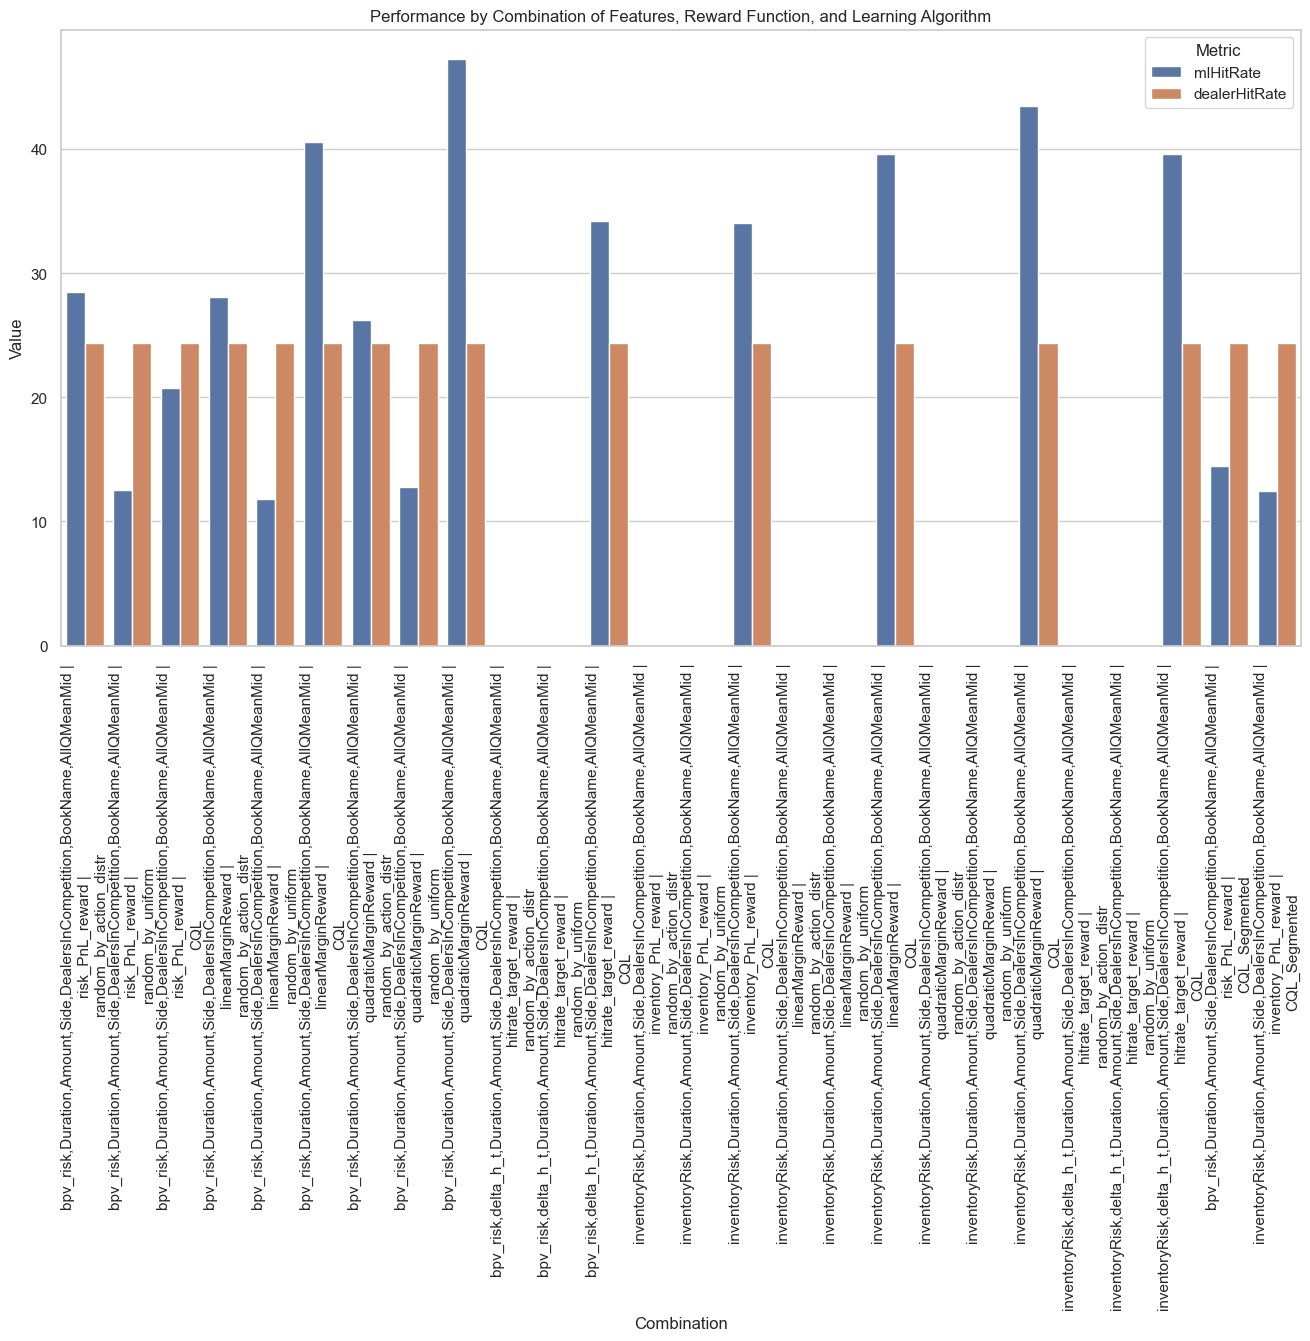

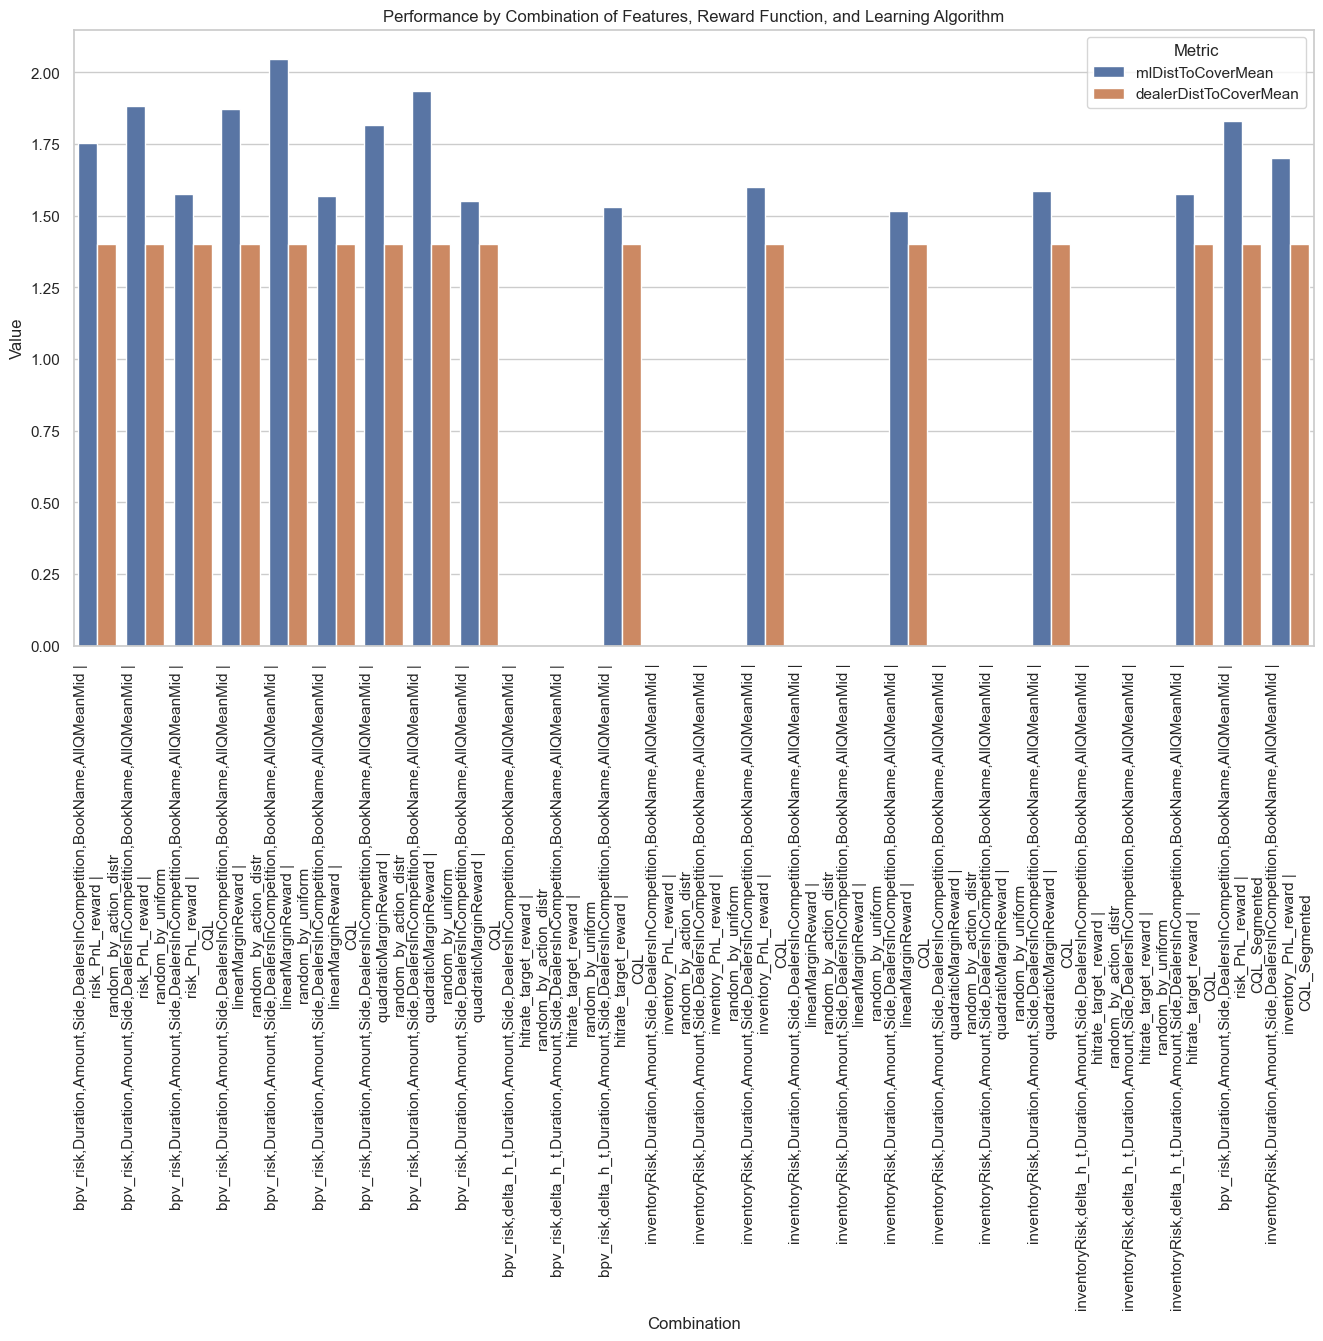

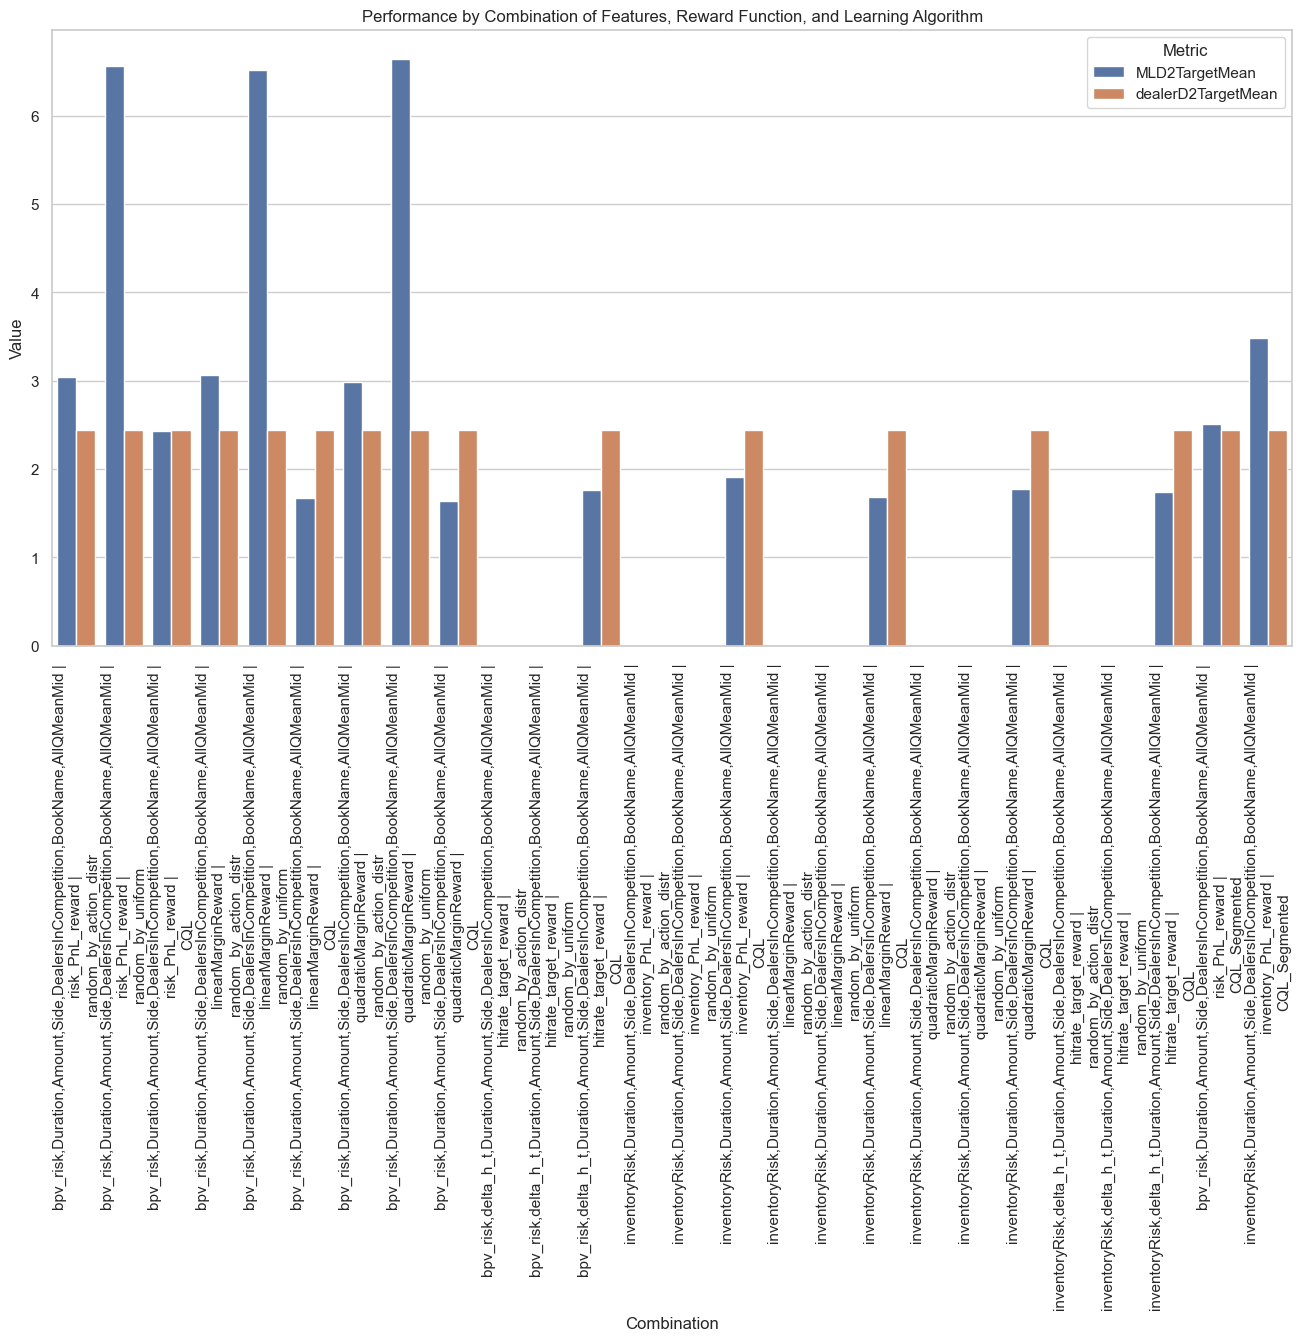

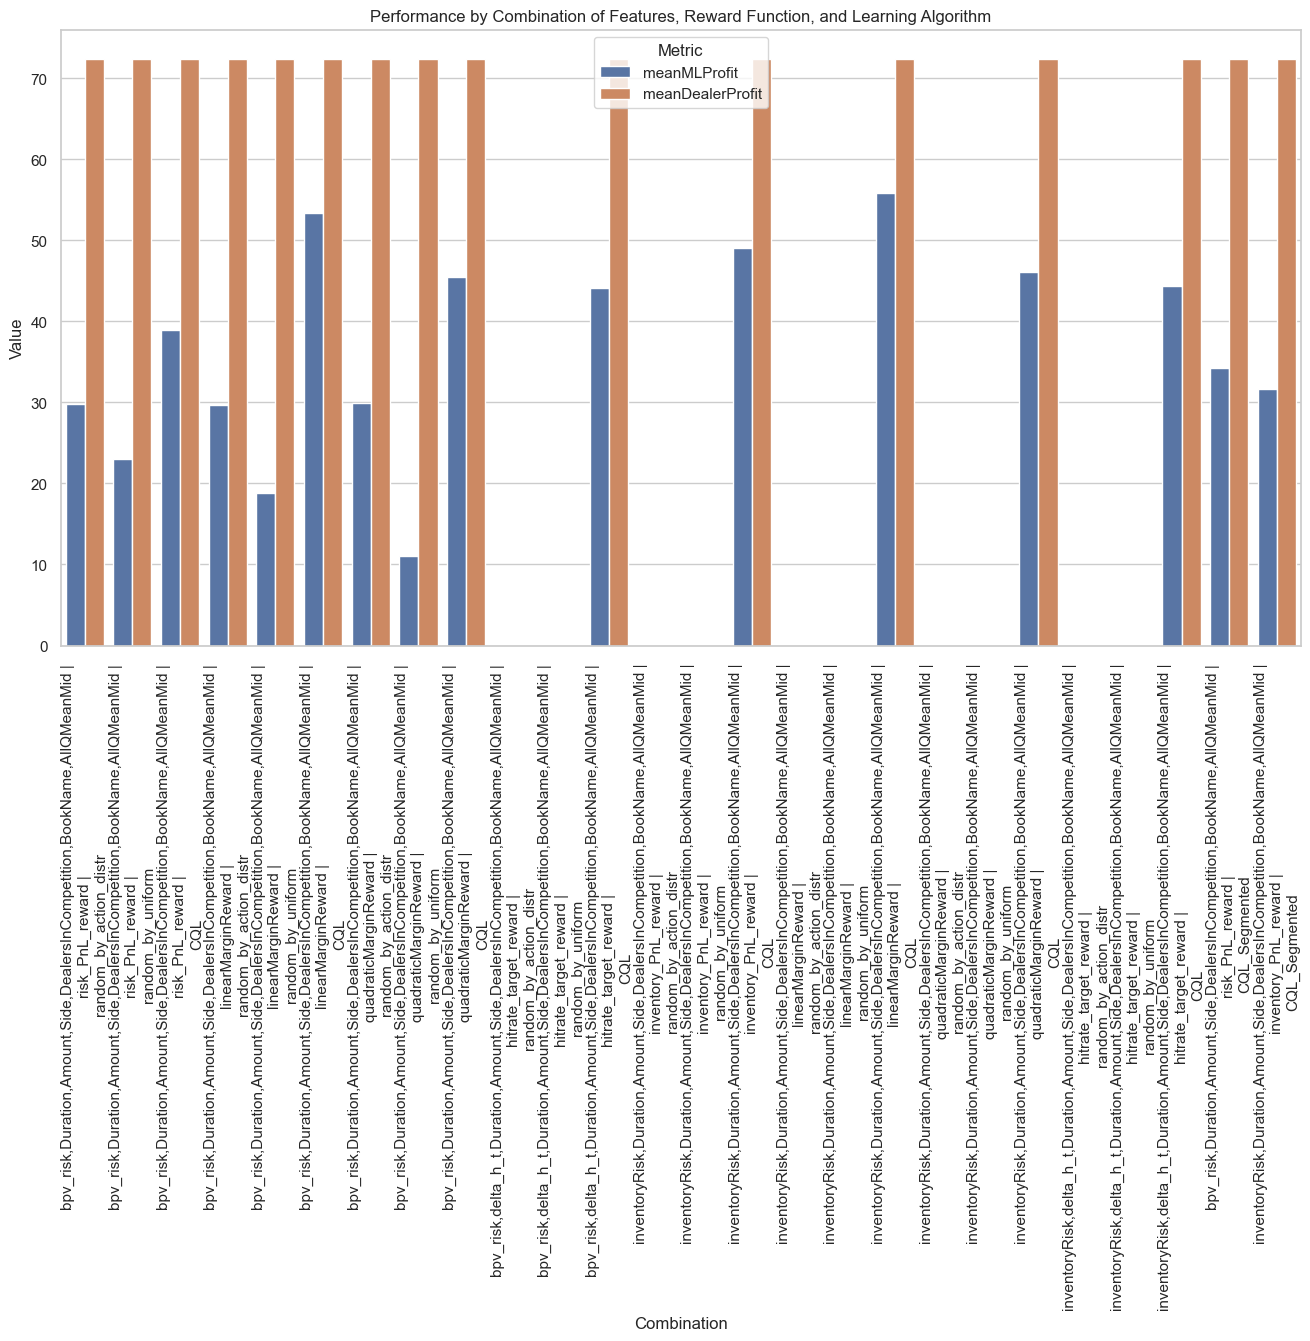

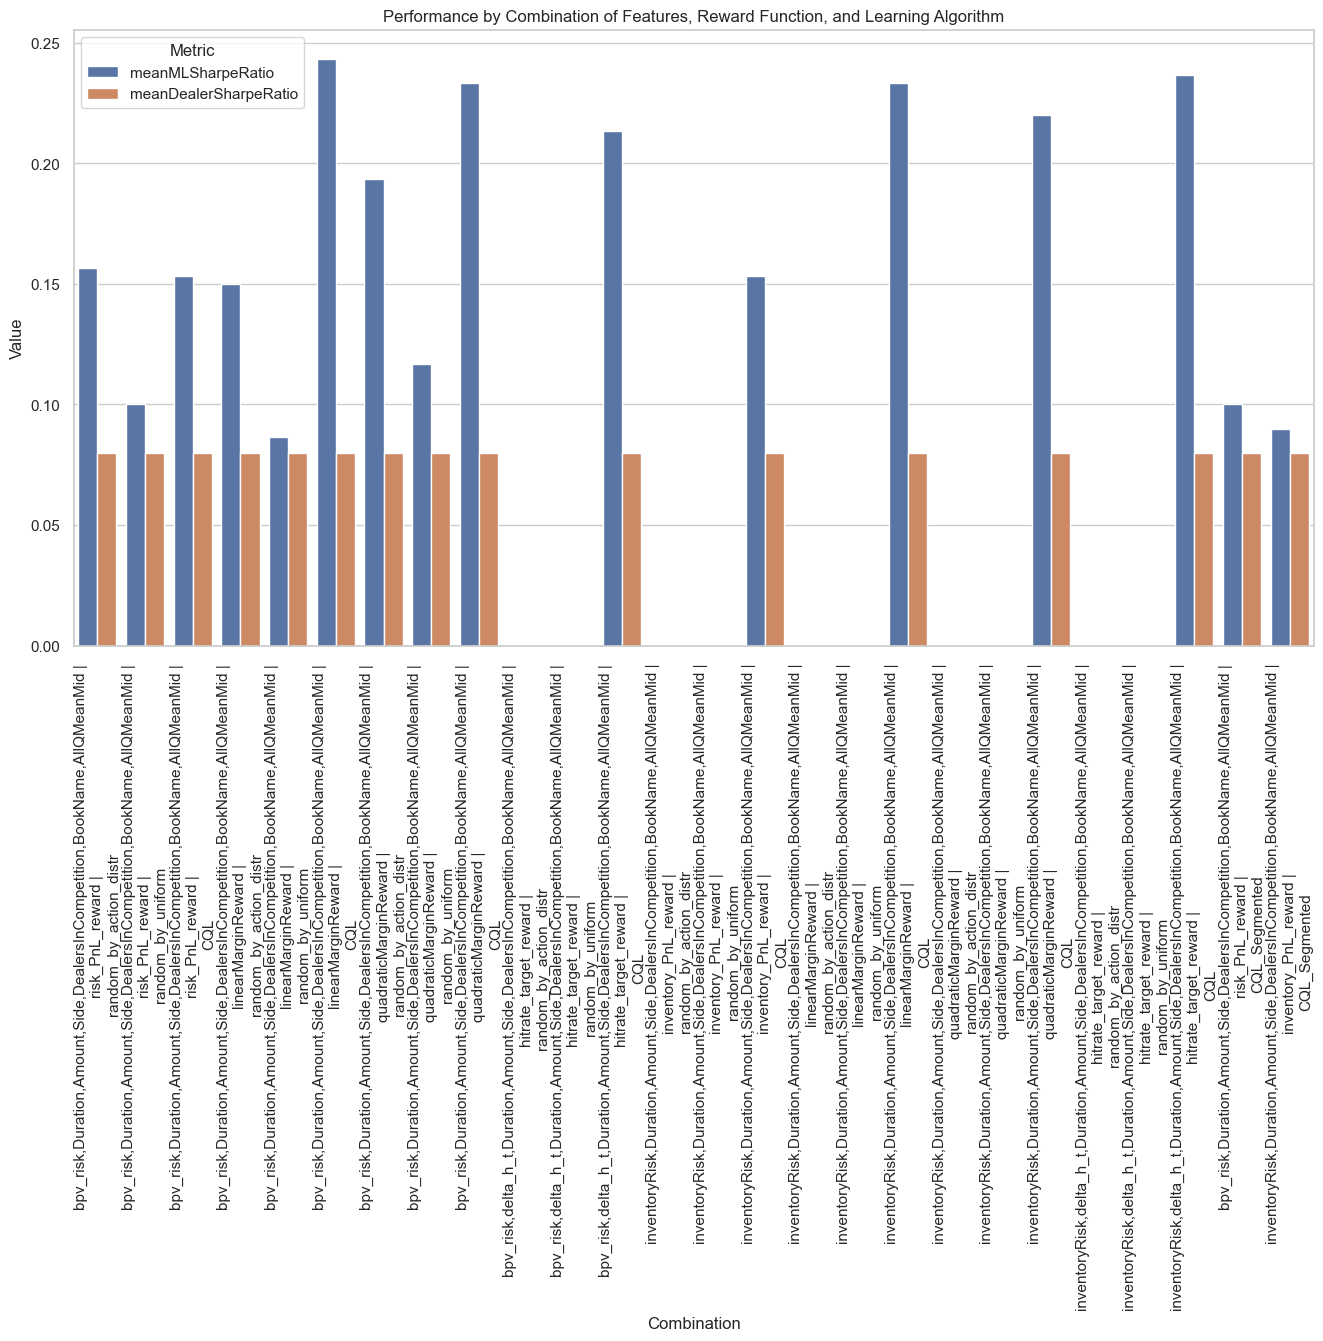

In [ ]:
eval_utils.visualize_trader_vs_ML_metrics(results_df=results_df.copy())